In [1]:
import os
import glob
import numpy as np
import tqdm
import yaml
import pandas as pd

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN, GCNSupervisedGraphClassification
from stellargraph import StellarDiGraph
from sklearn import model_selection

import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from matplotlib import pyplot as plt

%matplotlib inline

2021-07-28 02:30:14.567178: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 02:30:15.527679: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-28 02:30:15.573521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-28 02:30:15.574087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-07-28 02:30:15.574112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 02:30:15.576194: I tensorflow/stream_executor/platfor

In [2]:
data_dir = '/home/nonroot/experiment/results/notebook/simplify-vs-cse'
info_file = os.path.join(data_dir, 'info.yaml')
representation = 'cfgcompact'
feature = 'boo'

In [3]:
def yaml_load(filename: str):
    with open(filename, 'rt') as f:
        return yaml.load(f, Loader=yaml.FullLoader)

In [4]:
files = yaml_load(info_file)

graphs = []
labels = []

def create_graph(filename):
    data = np.load(filename, allow_pickle=True)
    indexes, features = zip(*data['nodes'])
    node_data = pd.DataFrame(features, index=indexes)
    edges = pd.DataFrame(data['edges'], columns=['source', 'target', 'type'])
    return StellarDiGraph(node_data, edges=edges, edge_type_column="type")

i =0 
for f in tqdm.tqdm(files):
    graph_file = os.path.join(data_dir, f"{f}_{feature}.npz")
    graph = create_graph(graph_file)
    class_file = os.path.join(data_dir, f"{f}_classes.yaml")
    info = yaml_load(class_file)
    #print(info)
    min_value = min(c['binary_size'] for c in info)
    label = [1 if c['binary_size'] == min_value else 0 for c in info].index(1)    
    graphs.append(graph)
    labels.append(label)
    
print(f'Loaded {len(graphs)} graphs')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 126.71it/s]

Loaded 2000 graphs


In [5]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,2000.0,2000.0
mean,65.3,99.1
std,37.2,59.6
min,1.0,0.0
25%,41.0,60.0
50%,58.0,88.0
75%,81.0,123.0
max,336.0,544.0


In [6]:
#label_names = ['0', '1']
graph_labels = pd.DataFrame(labels, columns=['labels'])
graph_labels.describe()

,labels
count,2000.000000
mean,0.500000
std,0.500125
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [7]:
graph_labels.value_counts().to_frame()

,0
labels,
0,1000
1,1000


In [8]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)
print(graph_labels)

      labels
0          0
1          1
2          0
3          1
4          0
...      ...
1995       0
1996       0
1997       0
1998       0
1999       0

[2000 rows x 1 columns]


In [16]:
def create_GCN_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    # model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])
    return model

def create_DGCNN_classification_model(generator, k):
    layer_sizes = [32, 32, 32, 1]

    dgcnn_model = DeepGraphCNN(
        layer_sizes=layer_sizes,
        activations=["tanh", "tanh", "tanh", "tanh"],
        k=k,
        bias=False,
        generator=generator,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()
    x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
    x_out = MaxPool1D(pool_size=2)(x_out)
    x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)
    x_out = Flatten()(x_out)
    x_out = Dense(units=128, activation="relu")(x_out)
    x_out = Dropout(rate=0.5)(x_out)
    predictions = Dense(units=1, activation="sigmoid")(x_out)
    
    model = Model(inputs=x_inp, outputs=predictions)
    # model.compile(optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"])
    return model

In [18]:
generator = PaddedGraphGenerator(graphs=graphs)

# GCN
# model = create_GCN_classification_model(generator)
# model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

# DCGNN
model = create_DGCNN_classification_model(generator, k=35)
model.compile(optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, 65)]   0                                            
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, None, 65)     0           input_13[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution_12 (GraphConv (None, None, 32)     2080        dropout_14[0][0]                 
                                                                 input_15[0][0]             

In [19]:
train_size = 0.9
validation_size = 0.1
test_size = 0.1

train_batch_size = 32
validation_batch_size = 1
test_batch_size = 1

train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels,
    train_size=train_size,
    test_size=test_size,
    stratify=graph_labels,
    shuffle=True,
)

train_graphs, val_graphs = model_selection.train_test_split(
    train_graphs,
    train_size=train_size,
    test_size=validation_size,
    stratify=train_graphs,
    shuffle=True,
)

gen = PaddedGraphGenerator(graphs=graphs)


train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=train_batch_size,
    symmetric_normalization=False,
)

val_gen = gen.flow(
    list(val_graphs.index - 1),
    targets=val_graphs.values,
    batch_size=validation_batch_size,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=test_batch_size,
    symmetric_normalization=False,
)

print("Generated Data")

Generated Data


In [20]:
history = model.fit(
    train_gen,
    epochs=100,
    verbose=True,
    validation_data=val_gen,
    shuffle=True
)

Epoch 1/100


/home/nonroot/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/sort_pooling_2/map/while/gradients/model_4/sort_pooling_2/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/sort_pooling_2/map/while/gradients/model_4/sort_pooling_2/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/sort_pooling_2/map/while/gradients/model_4/sort_pooling_2/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


51/51 [==============================] - 2s 26ms/step - loss: 0.6952 - acc: 0.5099 - val_loss: 0.6922 - val_acc: 0.5278
Epoch 2/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6944 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.4667
Epoch 3/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6909 - acc: 0.5241 - val_loss: 0.6938 - val_acc: 0.5111
Epoch 4/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6928 - acc: 0.5167 - val_loss: 0.6924 - val_acc: 0.5333
Epoch 5/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6877 - acc: 0.5444 - val_loss: 0.6931 - val_acc: 0.4667
Epoch 6/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6900 - acc: 0.5253 - val_loss: 0.6937 - val_acc: 0.5056
Epoch 7/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6881 - acc: 0.5420 - val_loss: 0.6923 - val_acc: 0.4944
Epoch 8/100
51/51 [==============================] - 1s 22ms/step - loss: 0.6893 - acc: 

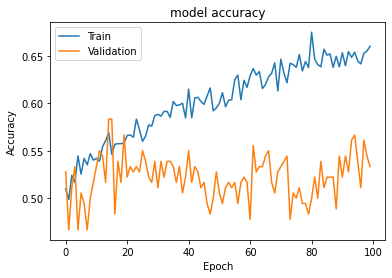

In [21]:
plt.plot(np.array(history.history['acc']))
plt.plot(np.array(history.history['val_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

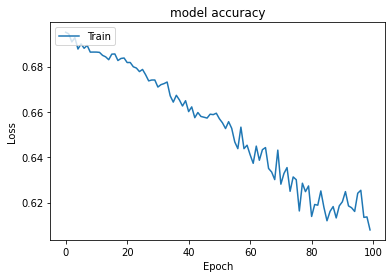

In [26]:
plt.plot(np.array(history.history['loss']))
plt.title('model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
test_metrics = model.evaluate(test_gen)
print("Test Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print(f"\t{name}: {val:0.4f}")

200/200 [==============================] - 0s 871us/step - loss: 0.7426 - acc: 0.5400
Test Set Metrics:
	loss: 0.7426
	acc: 0.5400


In [27]:
train_size = 0.9
validation_size = 0.1
test_size = 0.1

train_batch_size = 64
validation_batch_size = 1
test_batch_size = 1

train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels,
    train_size=train_size,
    test_size=test_size,
    stratify=graph_labels,
    shuffle=True,
)

train_graphs, val_graphs = model_selection.train_test_split(
    train_graphs,
    train_size=train_size,
    test_size=validation_size,
    stratify=train_graphs,
    shuffle=True,
)

gen = PaddedGraphGenerator(graphs=graphs)


train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=train_batch_size,
    symmetric_normalization=False,
)

val_gen = gen.flow(
    list(val_graphs.index - 1),
    targets=val_graphs.values,
    batch_size=validation_batch_size,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=test_batch_size,
    symmetric_normalization=False,
)

print("Generated Data")

Generated Data


In [28]:
history = model.fit(
    train_gen,
    epochs=500,
    verbose=True,
    validation_data=val_gen,
    shuffle=True
)

Epoch 1/500
26/26 [==============================] - 1s 50ms/step - loss: 0.6329 - acc: 0.6346 - val_loss: 0.6689 - val_acc: 0.6167
Epoch 2/500
26/26 [==============================] - 1s 49ms/step - loss: 0.6288 - acc: 0.6340 - val_loss: 0.6594 - val_acc: 0.6056
Epoch 3/500
26/26 [==============================] - 1s 49ms/step - loss: 0.6274 - acc: 0.6333 - val_loss: 0.6635 - val_acc: 0.5833
Epoch 4/500
26/26 [==============================] - 1s 48ms/step - loss: 0.6321 - acc: 0.6451 - val_loss: 0.6576 - val_acc: 0.5778
Epoch 5/500
26/26 [==============================] - 1s 48ms/step - loss: 0.6317 - acc: 0.6426 - val_loss: 0.6737 - val_acc: 0.6056
Epoch 6/500
26/26 [==============================] - 1s 48ms/step - loss: 0.6290 - acc: 0.6414 - val_loss: 0.6588 - val_acc: 0.6056
Epoch 7/500
26/26 [==============================] - 1s 49ms/step - loss: 0.6289 - acc: 0.6333 - val_loss: 0.6619 - val_acc: 0.6056
Epoch 8/500
26/26 [==============================] - 1s 48ms/step - loss: 0.

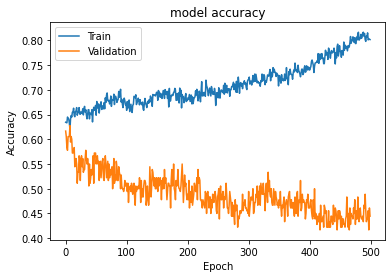

In [29]:
plt.plot(np.array(history.history['acc']))
plt.plot(np.array(history.history['val_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

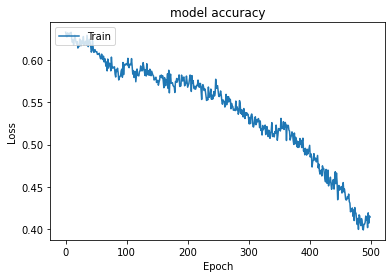

In [30]:
plt.plot(np.array(history.history['loss']))
plt.title('model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()